In [3]:
import copy
from PIL import Image
from glob import glob
from matplotlib import cm, image, patches, pyplot as plt
import io

import cv2
import numpy as np


## SET-UP

In [14]:
base_dir = "/home/z/MVPC10/CODE/pplcnt_model/data/"

data_prev = "20220428-075507_03"
data_now = "20220428-075608_03"

data_prev_ir = f"{base_dir}{data_prev}_IR.png"
data_prev_rgb = f"{base_dir}{data_prev}_RGB.jpg"
data_now_ir = f"{base_dir}{data_now}_IR.png"
data_now_rgb = f"{base_dir}{data_now}_RGB.jpg"

files = []
files.append(data_prev_ir)
files.append(data_prev_rgb)
files.append(data_now_ir)
files.append(data_now_rgb)

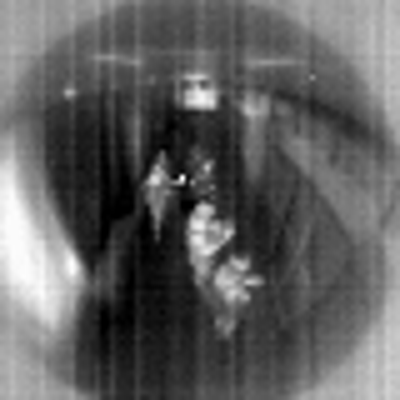

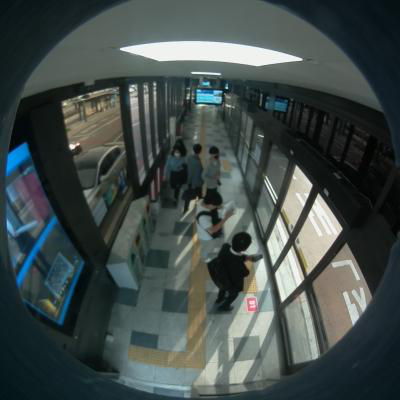

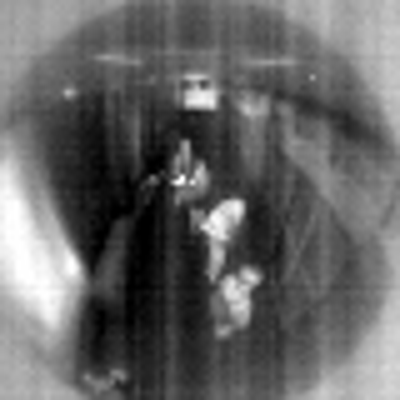

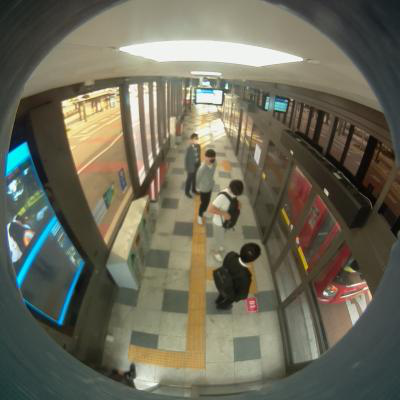

In [91]:
rgb_list = []
ir_list = []
for i in files:
    if "RGB" in i:
        img = Image.open(i) #.convert('RGB')
        arr = np.array(img)
        rgb_list.append(arr)
    elif "IR" in i:
        img = Image.open(i).convert('L')
        arr = np.array(img)
        ir_list.append(arr)

    resized = img.resize([400,400])
    display(resized)
    # resized = img.resize([1200,1200])
    # display(resized)



In [55]:

print(rgb_list[0])
print(ir_list[0])


[[[ 7 18 20]
  [ 7 18 20]
  [ 7 18 20]
  ...
  [ 6 17 19]
  [ 6 17 19]
  [ 6 17 19]]

 [[ 7 18 20]
  [ 7 18 20]
  [ 7 18 20]
  ...
  [ 6 17 19]
  [ 6 17 19]
  [ 6 17 19]]

 [[ 7 18 20]
  [ 7 18 20]
  [ 7 18 20]
  ...
  [ 6 17 19]
  [ 6 17 19]
  [ 6 17 19]]

 ...

 [[ 3 21 25]
  [ 3 21 25]
  [ 2 20 24]
  ...
  [ 8 23 28]
  [ 8 23 28]
  [ 8 23 28]]

 [[ 1 19 23]
  [ 2 20 24]
  [ 2 20 24]
  ...
  [ 8 23 28]
  [ 8 23 28]
  [ 8 23 28]]

 [[ 0 18 22]
  [ 1 19 23]
  [ 3 21 25]
  ...
  [ 8 23 28]
  [ 8 23 28]
  [ 8 23 28]]]
[[156 161 171 ... 187 182 177]
 [153 161 168 ... 185 177 177]
 [160 159 166 ... 186 180 170]
 ...
 [173 169 181 ... 208 202 192]
 [175 172 188 ... 209 198 200]
 [165 170 178 ... 205 195 192]]


In [62]:

w, h, c = rgb_list[0].shape
print(w, h, c)

w, h = ir_list[0].shape
print(w, h)


400 400 3
80 80


## AUTO LABEL

In [85]:
def tranformer(rgb, ir, id):
    w_re, h_re = ir.shape[:2]
    # scale = 1200//w_re
    scale = 5
    reshaped_size = (w_re*scale, h_re*scale)

    rgb_reshaped = cv2.resize(rgb, reshaped_size)
    ir_reshaped = cv2.resize(ir, reshaped_size)

    device_id = id

    if device_id == "01": x, y, xw, yh = -1.53*scale, -6.73*scale, 1.16, 1.16
    elif device_id == "02": x, y, xw, yh = -8.93*scale, -8.6*scale, 1.16, 1.16
    elif device_id == "03": x, y, xw, yh = -2.4*scale, -8.53*scale, 1.16, 1.16
    elif device_id == "05": x, y, xw, yh = -2.4*scale, -8.53*scale, 1.16, 1.16
    elif device_id == "07": x, y, xw, yh = -8.2*scale, -7.6*scale, 1.16, 1.16
    else: x, y, xw, yh = 0, 0, 1, 1

    alpha = 1.0
    while True:
        matrix = np.float32([[xw, 0, y],
                             [0, yh, x],
                             [0, 0, 1]])
        warped = cv2.warpPerspective(rgb_reshaped, matrix, reshaped_size)
        overlayed = cv2.addWeighted(src1=ir_reshaped, alpha=alpha, src2=warped, beta=1-alpha, gamma=0)
        # cv2.putText(overlayed, f'alpha:{alpha:.2f}, x:{x}, y:{y}, w:{w:.2f}, h:{h:.2f}', org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255,255,255), thickness=1,) # lineType=cv2.LINE_AA)
        cv2.imshow("overlayed", overlayed)

        key = cv2.waitKey()
        # up: 82, down:84, left: 81, right: 83
        if key == ord('q'):
            alpha -= 0.02
            if alpha < 0: alpha = 0
        elif key == ord('w'):
            alpha += 0.02
            if alpha > 1: alpha = 1

        elif key == 82: x -= 1
        elif key == 84: x += 1

        elif key == 81: y -= 1
        elif key == 83: y += 1

        elif key == ord('a'): xw -= 0.01
        elif key == ord('s'): xw += 0.01

        elif key == ord('z'): yh -= 0.01
        elif key == ord('x'): yh += 0.01

        elif key == ord('p'): cv2.imwrite("warped.jpg", warped)

        elif key == 27:
            cv2.destroyAllWindows()
            break

        # print(f'{x}, {y}, {xw:.2f}, {yh:.2f}')


In [ ]:
ir = cv2.imread(data_prev_ir)
rgb = cv2.imread(data_prev_rgb)

tranformer(rgb, ir, "03")


In [ ]:
rgb = cv2.imread("warped.jpg")

tranformer(rgb, ir, "00")


In [ ]:
'''
python /path/to/detectron2/projects/TensorMask/train_net.py --config-file configs/tensormask_R_50_FPN_6x.yaml --eval-only MODEL.WEIGHTS /path/to/model_checkpoint
''''

## MODEL

In [64]:
def normalize(img, min=0, max=255, w=80, h=80):
    """
    :return: normalize img from min to max and reshape to w, h
    """
    norm = np.array([])
    for i in img:
        norm = np.append(norm, (i/max), axis=0).astype(np.float16)
    norm = np.reshape(norm, (w, h))
    return norm

In [56]:
def add_channel(img):
    # img = np.expand_dims(img_arr, axis=-1)
    # img = img_arr.reshape(img_arr.shape[0], img_arr.shape[1], 1)
    reshaped_img = img.reshape(img.shape[0], img.shape[1], 1)
    return reshaped_img

In [57]:
def loop_tiler(img, t_w, t_h, dtype):
    w1, h1 = w//t_w, h//t_h
    tile = np.zeros((h1, w1, t_h, t_w)).astype(dtype)
    y = x = 0
    for i in range(0, h, t_h):
        for j in range(0, w, t_w):
            tile[y][x] = img[i:i+t_h, j:j+t_w]
            x += 1
        y += 1
        x = 0
    return tile, w1, h1

In [58]:
def reshape_tiler(img, t_w, t_h):
    w1, h1 = w//t_w, h//t_h
    tile = img.reshape(h1, t_h, w1, t_w)
    tile = tile.swapaxes(1, 2)
    return tile, w1, h1

In [59]:
def cutoff_filter(img, min, max, nmin, nmax):
    li = []
    for i in img:
        for j in i:
            if j < min: j = nmin
            if j > max: j = nmin
            li.append(j)

    return li


In [14]:
def tiler(img, t_w, t_h):
    tile, rows, columns = loop_tiler(img, t_w, t_h)
    tli = []
    n, m = 0, 0
    for i in range(rows*columns):
        t = tile[n,m]
        m += 1
        if m == rows:
            n += 1
            m = 0
        if n == columns: n = 0
        tli.append(t)
    return tli

In [15]:
# 80    2 2 2 2 5    2 4 6 8 16   20 40
def tile_plotter(img, t_w=80, t_h=80, min=0, max=255, dtype=int, color=cm.magma):
    tile, rows, columns = loop_tiler(img, t_w, t_h, dtype)
    fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=[20,20])
    n, m = 0, 0
    grid = rows*columns
    if grid==1: plt.imshow(tile[n,m], cmap=color, vmin=min, vmax=max,)
    else:
        for i in range(grid):
            ax[n,m].axis('off')
            ax[n,m].imshow(tile[n,m], cmap=color, vmin=min, vmax=max,)
            m += 1
            if m == rows:
                n += 1
                m = 0
            if n == columns: n = 0

    return plt

In [17]:
reshaped_img = add_channel(img_arr)
w, h, c = reshaped_img.shape
print(w, h, c)
print(reshaped_img[:4,:4,:])

80 80 1
[[[182]
  [196]
  [195]
  [203]]

 [[181]
  [197]
  [195]
  [210]]

 [[189]
  [199]
  [195]
  [206]]

 [[191]
  [200]
  [191]
  [209]]]


In [18]:
normed_img = normalize(img_arr, 0, 255, w, h)
print(normed_img.shape)
# for i in normed_img:
#     print(i)
print(normed_img[0])
print(normed_img[79])


(80, 80)
[0.714  0.7686 0.7646 0.796  0.792  0.788  0.7803 0.7725 0.749  0.757
 0.7803 0.7686 0.7725 0.7607 0.757  0.7764 0.698  0.788  0.753  0.718
 0.7295 0.7295 0.7373 0.6943 0.6904 0.6704 0.639  0.5845 0.612  0.596
 0.596  0.5566 0.545  0.5527 0.604  0.5215 0.596  0.545  0.5605 0.502
 0.596  0.5527 0.6    0.5845 0.569  0.5605 0.533  0.5923 0.604  0.6665
 0.6743 0.706  0.7217 0.7256 0.6904 0.7373 0.7295 0.7334 0.784  0.7764
 0.7686 0.749  0.784  0.7686 0.82   0.8    0.816  0.796  0.82   0.7764
 0.7803 0.8354 0.8276 0.8276 0.7803 0.8315 0.753  0.8315 0.855  0.8037]
[0.749  0.8    0.7803 0.8315 0.8237 0.8237 0.796  0.8115 0.7803 0.7725
 0.792  0.784  0.7686 0.749  0.7334 0.7217 0.612  0.608  0.502  0.4119
 0.3882 0.3372 0.341  0.2903 0.2903 0.2864 0.2666 0.2393 0.2432 0.2744
 0.298  0.2471 0.2235 0.2744 0.302  0.2471 0.341  0.306  0.3254 0.2825
 0.3647 0.3647 0.3882 0.4    0.4    0.357  0.3176 0.3687 0.3687 0.4275
 0.4275 0.4392 0.4119 0.4314 0.396  0.4666 0.498  0.498  0.5923 0.643
 

In [19]:
tile, rows, columns = loop_tiler(normed_img, 8, 8, np.float16)
print(tile.shape)
# for i, j in enumerate(tile):
#     print(i, j)
tile[9,9]

(10, 10, 8, 8)


array([[0.8315, 0.8315, 0.8237, 0.855 , 0.792 , 0.847 , 0.902 , 0.8784],
       [0.8706, 0.851 , 0.851 , 0.8745, 0.82  , 0.8823, 0.898 , 0.89  ],
       [0.847 , 0.863 , 0.8433, 0.863 , 0.82  , 0.859 , 0.8706, 0.8667],
       [0.863 , 0.8276, 0.8237, 0.863 , 0.8237, 0.8823, 0.902 , 0.8706],
       [0.855 , 0.8394, 0.8354, 0.8667, 0.8   , 0.89  , 0.89  , 0.8667],
       [0.859 , 0.863 , 0.8433, 0.8667, 0.8037, 0.8745, 0.886 , 0.859 ],
       [0.8706, 0.8745, 0.8667, 0.886 , 0.8354, 0.886 , 0.9097, 0.8745],
       [0.8706, 0.8784, 0.847 , 0.894 , 0.8037, 0.8706, 0.898 , 0.847 ]],
      dtype=float16)

In [20]:
# tile, rows, columns = loop_tiler(img_arr, 8, 8, int)
# print(tile.shape)
# for i, j in enumerate(tile):
#     print(i, j)
# tile[0,0]


In [21]:
low_cut = 91
high_cut = 300

min = 0
max = 255

n_min = 0
n_max = 1

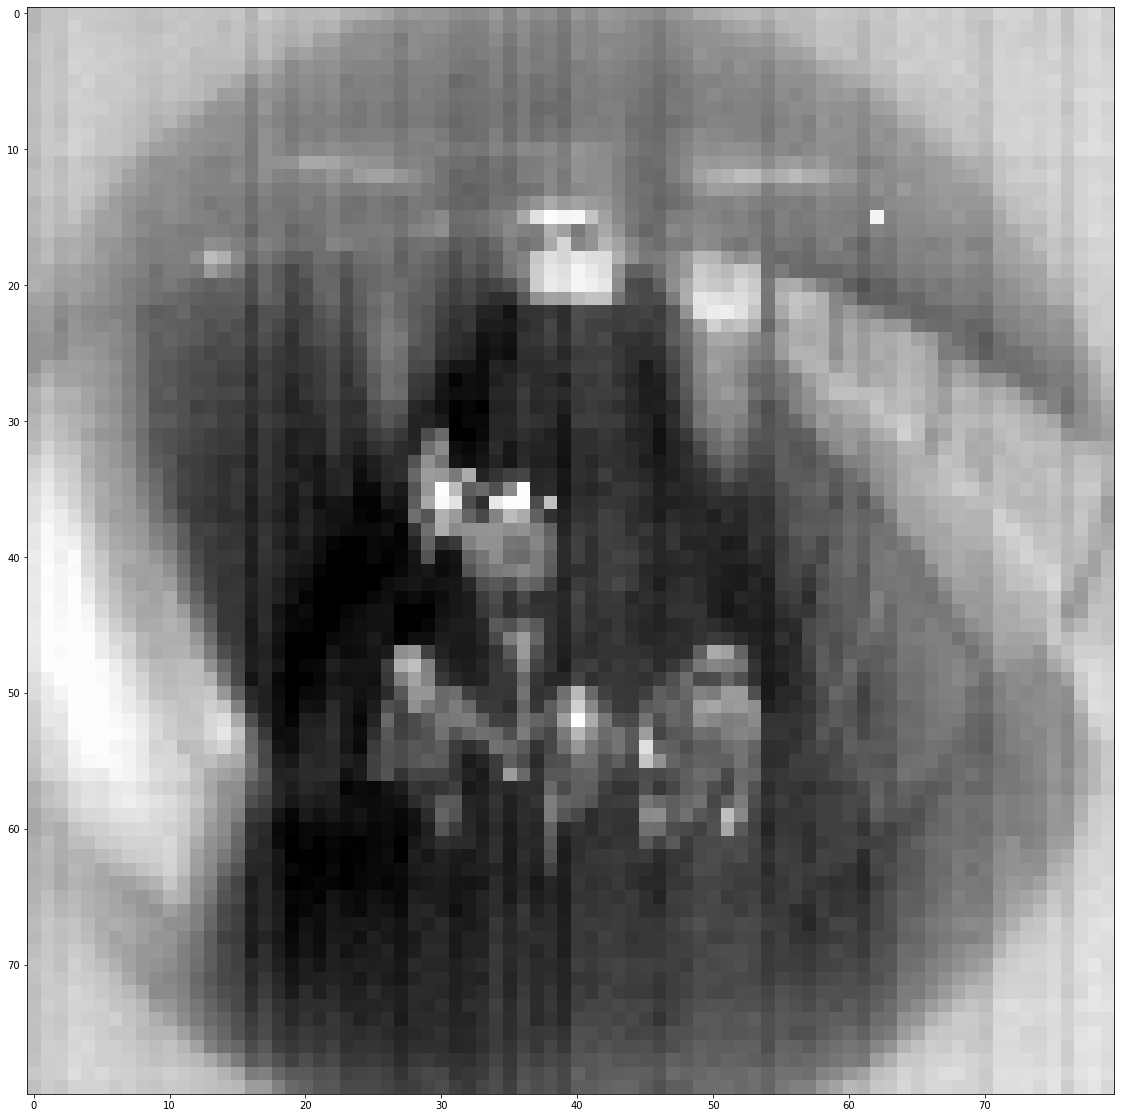

In [22]:
plot = tile_plotter(normed_img, 80, 80, 0, 1, float, cm.gray)
plot.show()

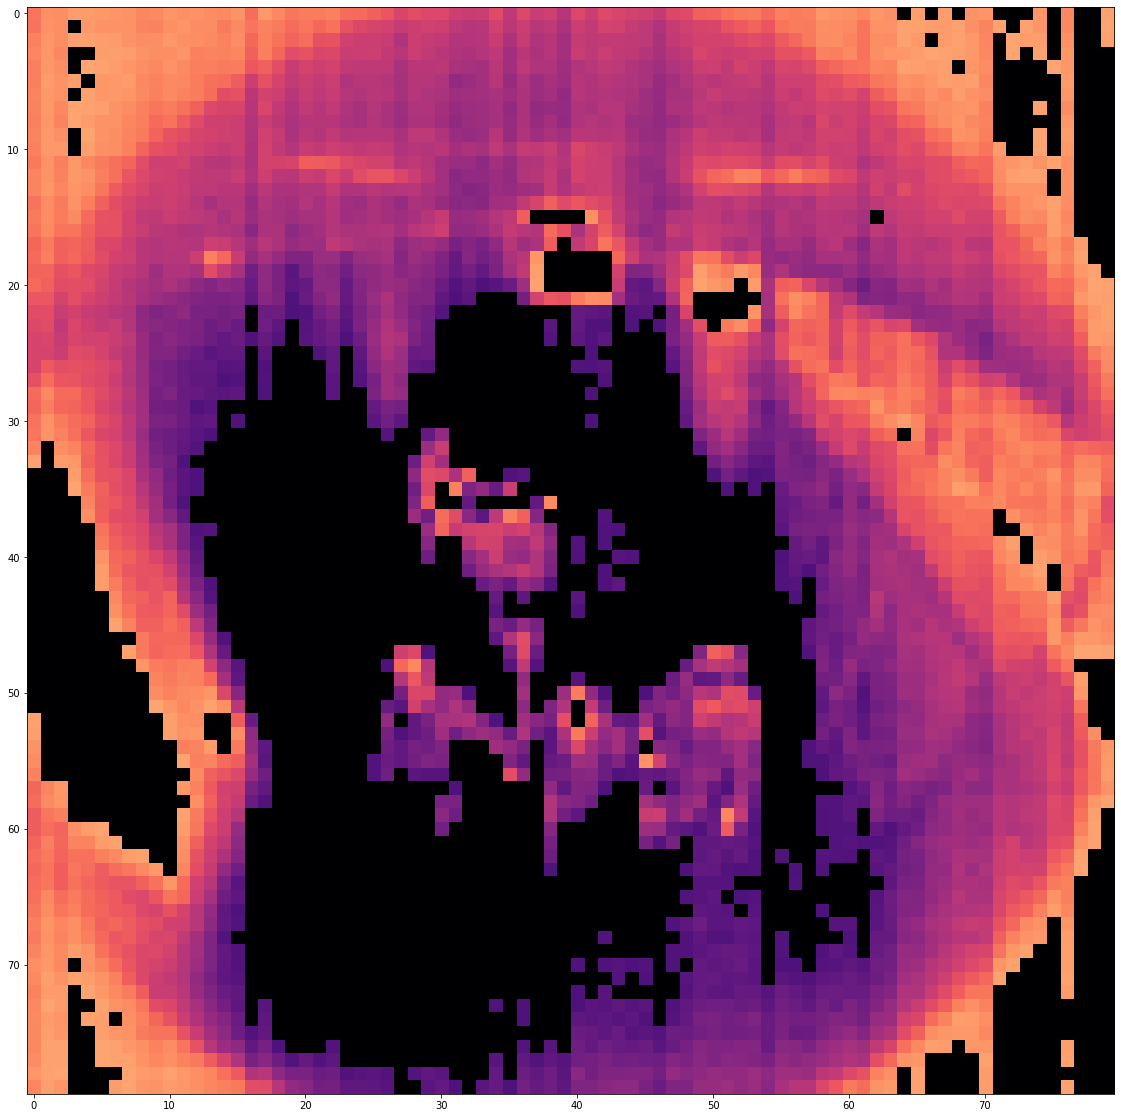

In [23]:
  plot = tile_plotter(img, 80, 80, min, max, int)
plot.show()

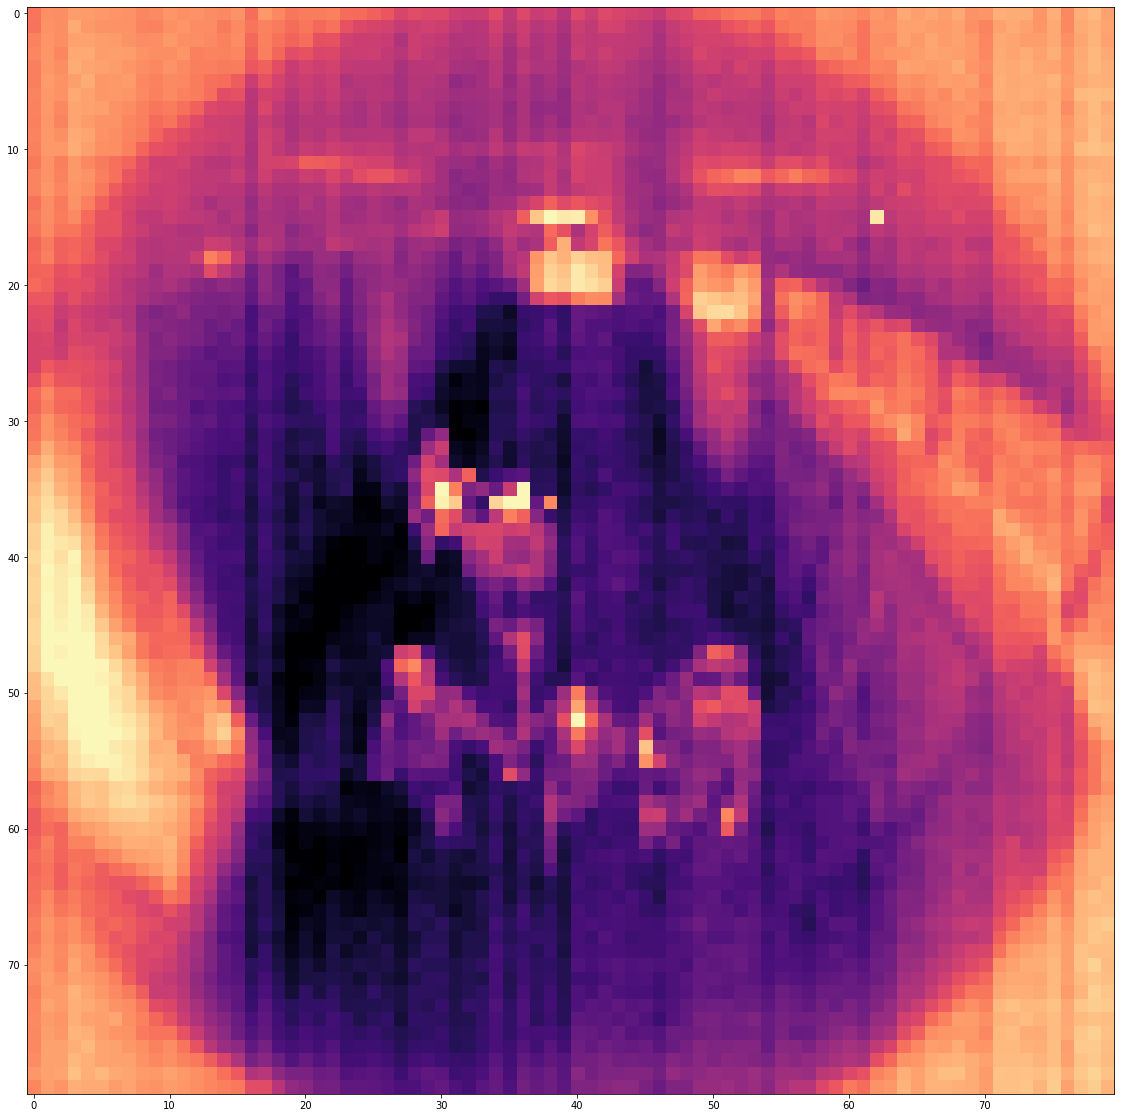

In [24]:
plot = tile_plotter(img_arr, 80, 80, min, max, int)
plot.show()

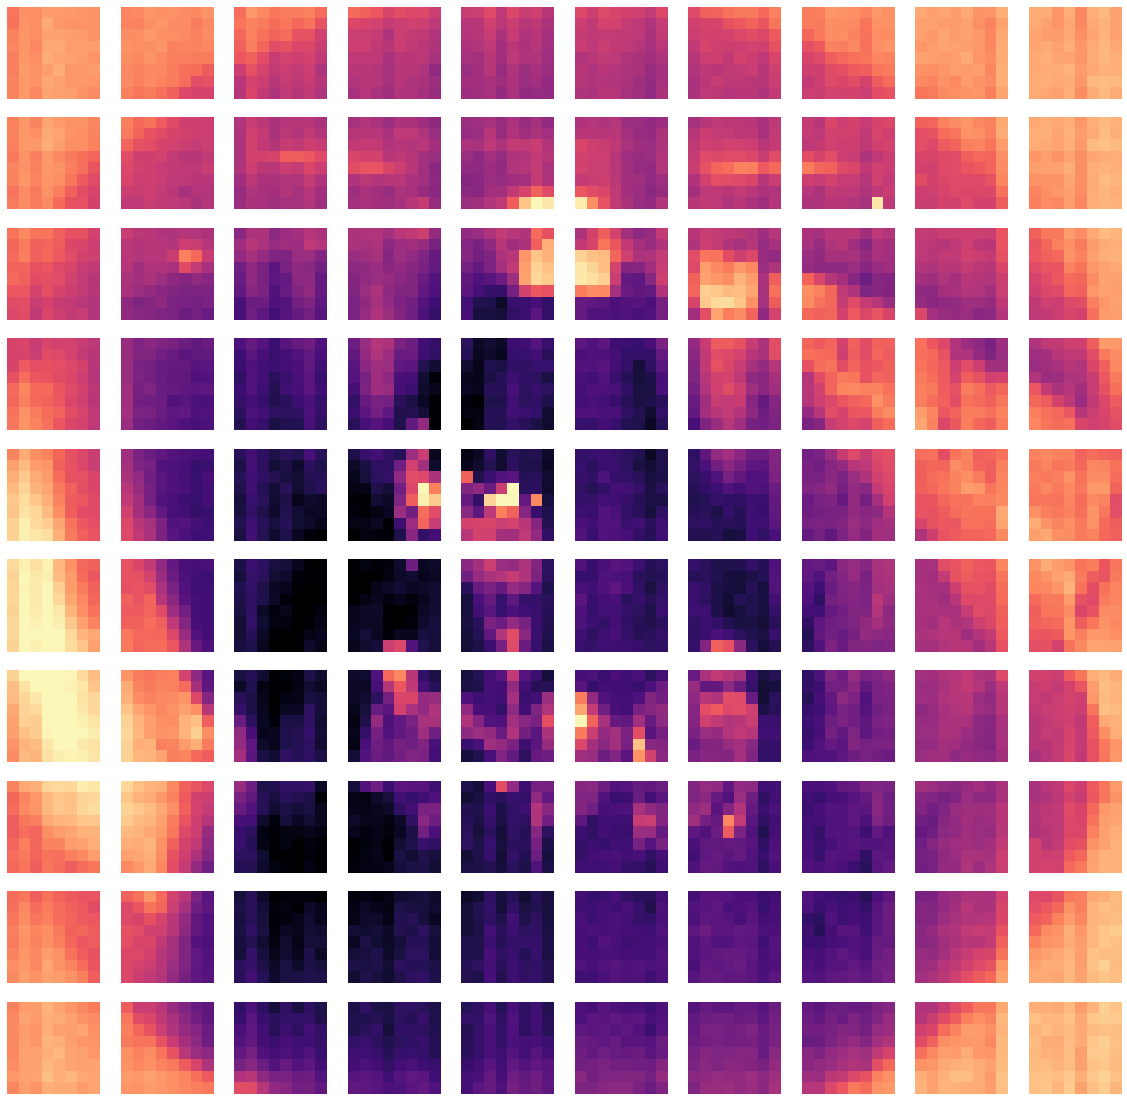

In [25]:
plot = tile_plotter(img_arr, 8, 8, min, max, int)
plot.show()

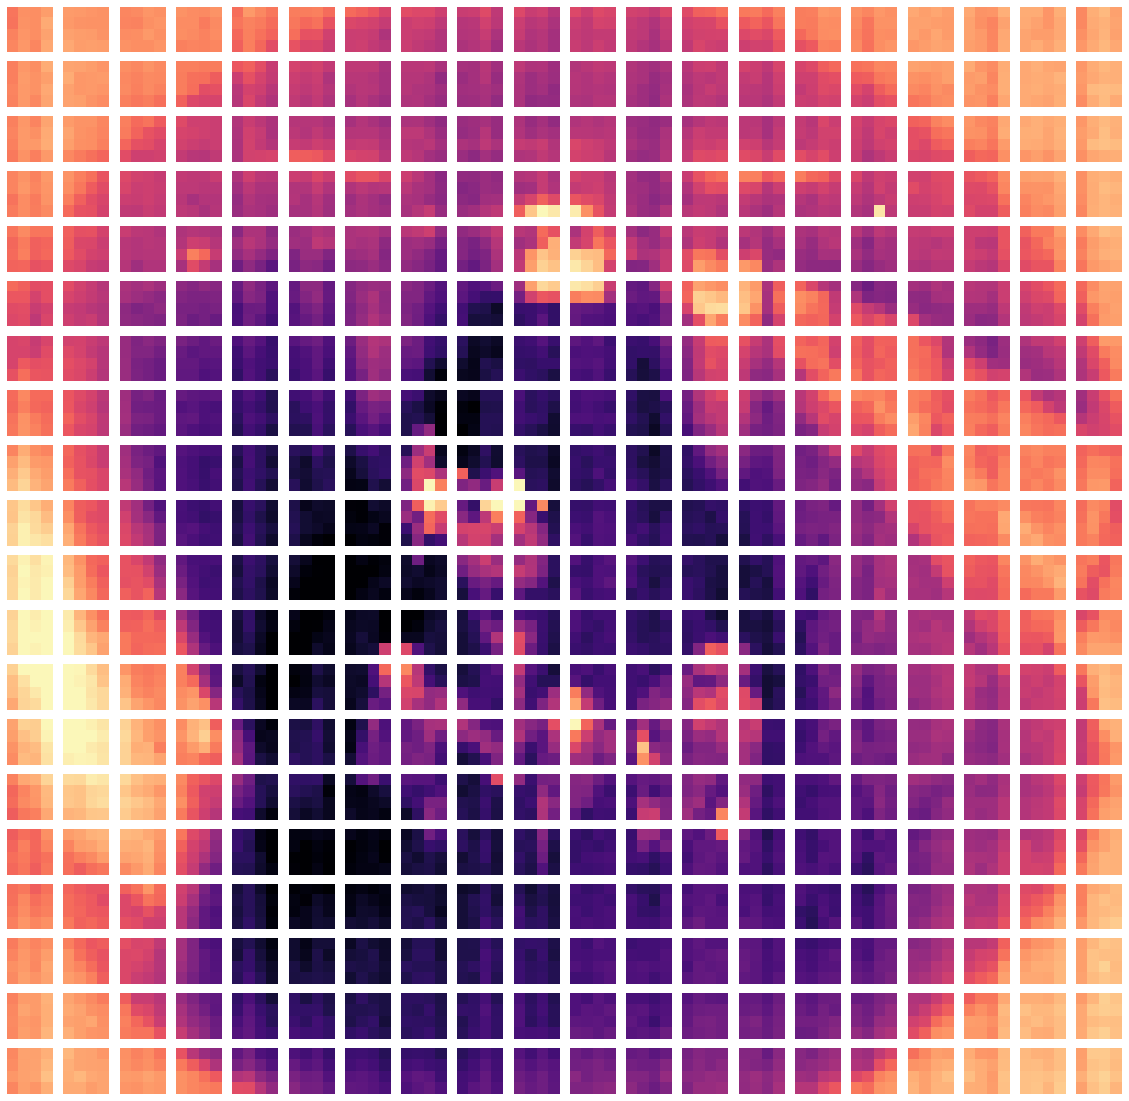

In [26]:
plot = tile_plotter(img_arr, 4, 4, min, max, int)
plot.show()

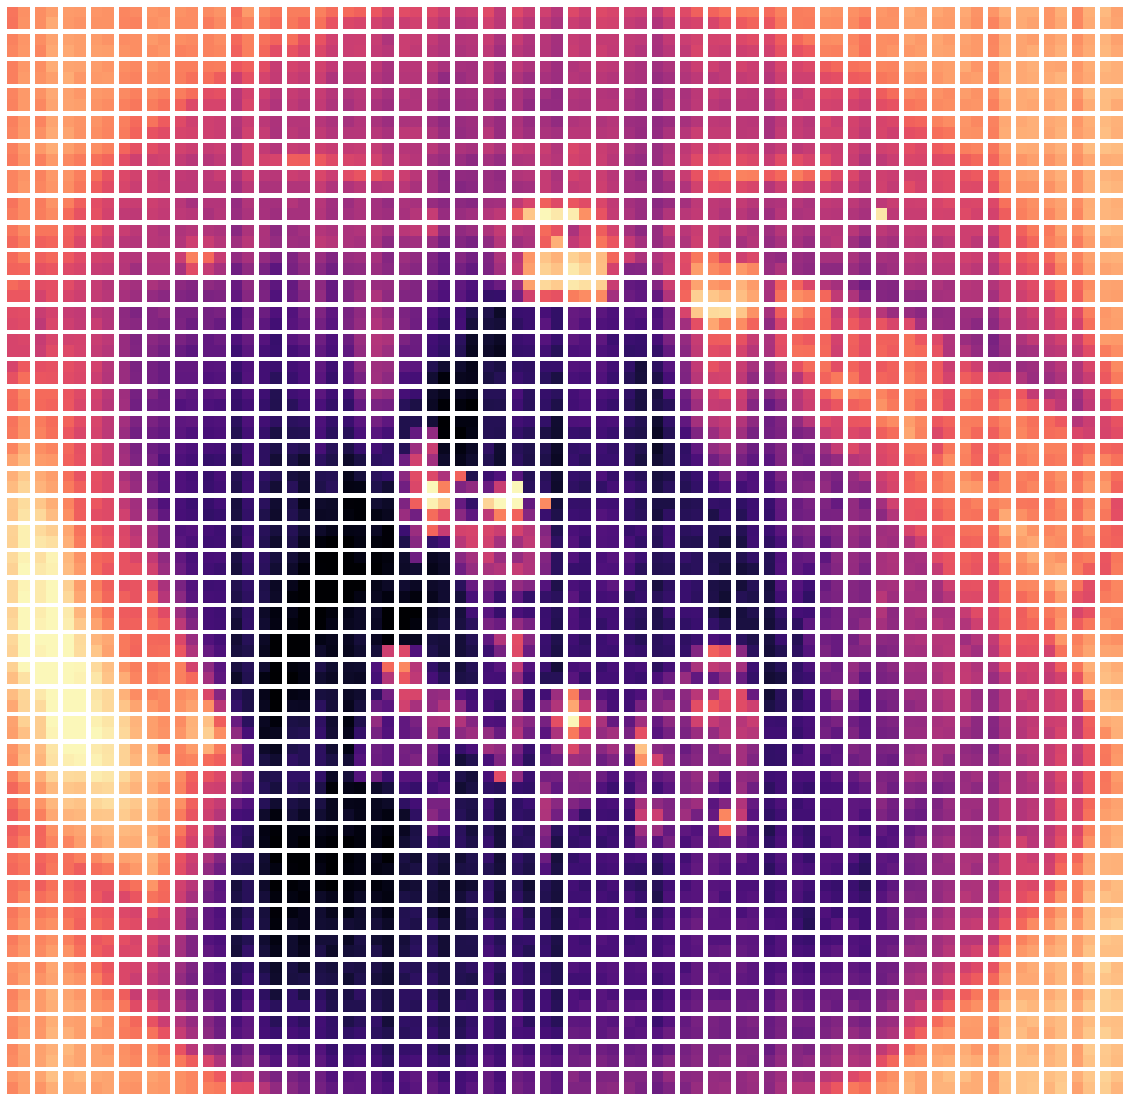

In [27]:
plot = tile_plotter(img_arr, 2, 2, min, max, int)
plot.show()

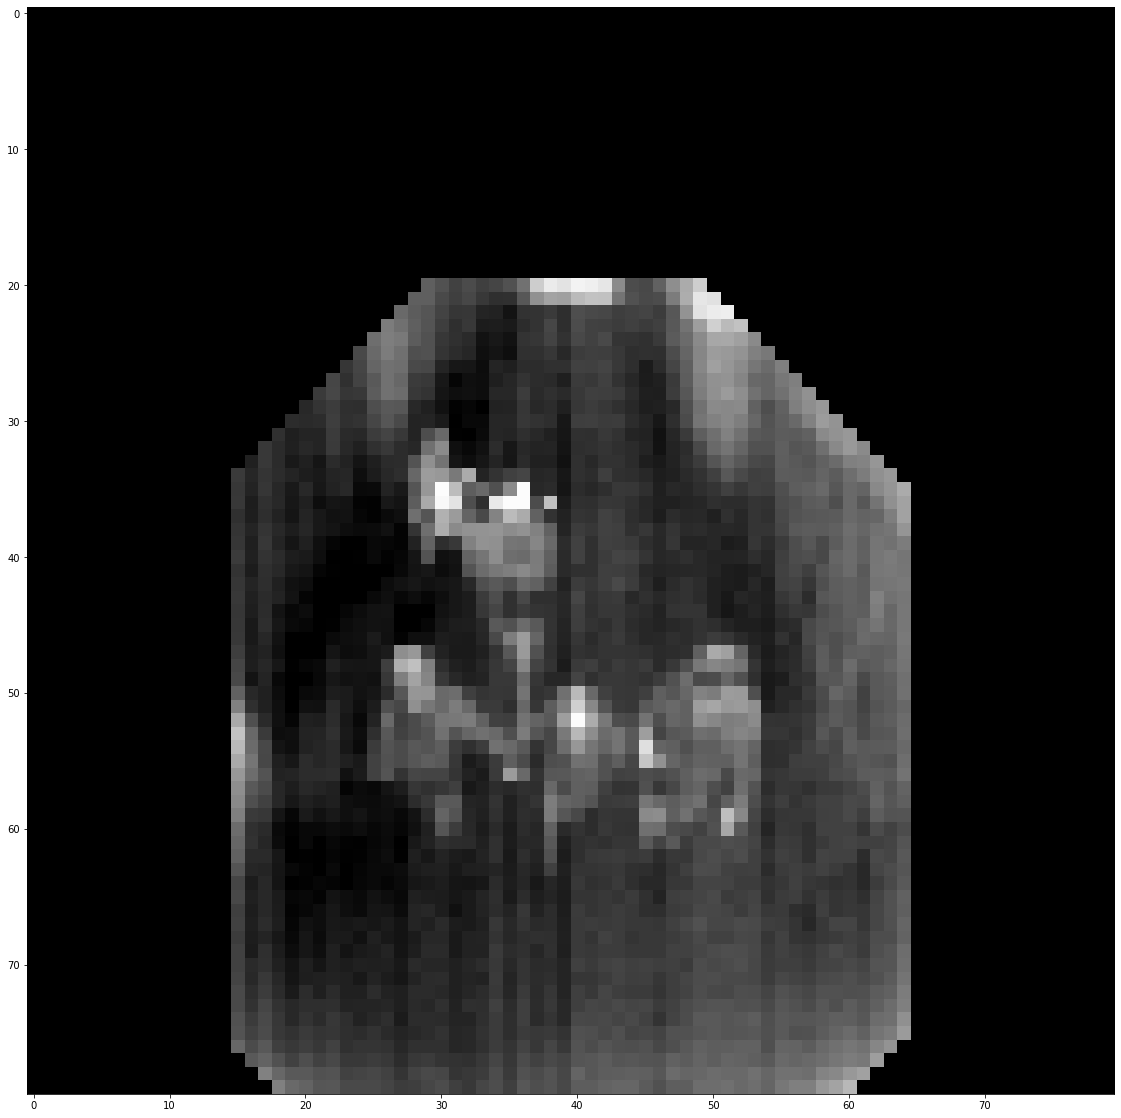

In [34]:
r = 45
center_x, center_y = 55, 39
img_arr1 = copy.deepcopy(img_arr)

# mask = np.array([])
mask = []
for x, i in enumerate(img_arr):
    for y, j in enumerate(i):
        disstance = abs(center_x-x)+abs(center_y-y)
        # print(x, y, disstance)
        if disstance > r:
            # mask = np.append(mask, (x,y))
            mask.append([x,y])
# side cut
side = 15
img_arr1[:,:side] = 0
img_arr1[:,w-side:] = 0

#  top cut
img_arr1[:20,:] = 0

# distance cut
for i in mask:
    img_arr1[i[0],i[1]] = 0


plt = tile_plotter(img_arr1, color=cm.gray)
plt.show()

In [29]:
def create_circular_mask(h=80, w=80, center=None, radius=None):
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        del radius
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X-center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [30]:
mask = create_circular_mask(h, w, (40,40), 40)
masked_img = copy.deepcopy(img_arr)
masked_img[~mask] = 0

In [31]:
center = (int(w/2), int(h/2))
radius = h/2
mask = create_circular_mask(h, w, center=center, radius=radius)
for i in mask:
    print(i)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
[False False False False

In [32]:
li = []
for i in mask:
    li.append(img_arr[i])

In [33]:
img_arr1 = copy.deepcopy(img_arr)
print(img_arr1)

cx = 39.
cy = 39.
r = 40.

img_arr1[(x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2] = 0.

plt.figure(figsize=(20,20))
plt.pcolormesh(x, y, img_arr1)
# plt.colorbar()
plt.show()

[[182 196 195 ... 212 218 205]
 [181 197 195 ... 210 214 207]
 [189 199 195 ... 208 215 205]
 ...
 [194 205 206 ... 223 226 219]
 [200 205 207 ... 226 232 223]
 [191 204 199 ... 222 229 216]]


TypeError: 'int' object is not subscriptable

In [ ]:
plt.figure(figsize=(20,20))
plt.pcolormesh(y, x, img_arr)
# plt.colorbar()
plt.show()

In [92]:
img = cv2.imread(files[0], cv2.IMREAD_GRAYSCALE)
# img = img_arr1

scale = 20
width = int(img.shape[1] * scale)
height = int(img.shape[0] * scale)

img = cv2.resize(img, (width,height), interpolation=cv2.INTER_AREA)

img_blur = cv2.GaussianBlur(img, (3,3), 0)

edges = cv2.Canny(image=img, threshold1=100, threshold2=200)
e = Image.fromarray(edges, mode='L')
e.show()

# plt = tile_plotter(edges, color=cm.gray)
# plt.show()

# img_arr1 = copy.deepcopy(edges)
#
# r = 45
# center_x, center_y = 55, 39
# # mask = np.array([])
# mask = []
# for x, i in enumerate(edges):
#     for y, j in enumerate(i):
#         disstance = abs(center_x-x)+abs(center_y-y)
#         # print(x, y, disstance)
#         if disstance > r:
#             # mask = np.append(mask, (x,y))
#             mask.append([x,y])
# side cut
side = 15
img_arr1[:,:side] = 0
img_arr1[:,w-side:] = 0

#  top cut
img_arr1[:20,:] = 0

# distance cut
for i in mask:
    img_arr1[i[0],i[1]] = 0

# plt = tile_plotter(img_arr1, color=cm.gray)
# plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()

background = Image.fromarray(img, mode='L')
foreground = Image.fromarray(edges, mode='L')


background.paste(foreground, (0, 0), foreground)
background.show()

